In [61]:
import numpy as np

from classy import Class    # CLASS python
import jax_cosmo as jc      # Jax-cosmo lib
import pyccl as ccl         # CCL python
from jemupk import *        # Jax Emulator of CLASS

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

In [63]:
import settings_gfpkq  as st         # configuration file (update 2/June/22)

In [64]:

# if true  use Omega_cdm h^2, Omega_b h^2, sigma8,       ns, h
# if false     Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h

In [66]:
emu = JemuPk(kernel_gf=kernel_RBF, kernel_pklin=kernel_RBF, kernel_qfunc=kernel_Matern12)
root_dir = "./"
if st.sigma8:
    tag="_sig8"
    print("Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h")
else:
    tag="_As"
    print("Using: Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h")
emu.load_all_gps(directory = root_dir + '/pknl_components' + st.d_one_plus+tag)

New Pk Emulator
Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h


In [90]:
jc.Planck15()

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [69]:
h_emu = 0.7
omega_c_emu = 0.3 * h_emu**2   # omega_c h^2
omega_b_emu = 0.05 * h_emu**2  #omega_b h^2
n_s_emu = 0.96
omega_c_ccl = omega_c_emu/h_emu**2
omega_b_ccl = omega_b_emu/h_emu**2

if st.sigma8:
    sigma8_emu = 0.8005244775226154
else:
    print("Use boltzmann_class to compute sigma8 from As")
    ln1010As_emu = 2.76
    As_emu = 10**(-10)*np.exp(ln1010As_emu)
    cosmo_ccl = ccl.Cosmology(
        Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
        h=h_emu, A_s=As_emu, n_s=n_s_emu,
        transfer_function='boltzmann_class', matter_power_spectrum='halofit')
    sigma8_emu = cosmo_ccl.sigma8()


cosmo_ccl = ccl.Cosmology(
    Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, n_s=n_s_emu, sigma8 = sigma8_emu,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')


In [70]:
cosmo_ccl

pyccl.Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8005244775226154, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, extra_parameters=None, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [71]:
params_emu = {'omega_cdm': omega_c_emu, 'omega_b': omega_b_emu, 
              'n_s': n_s_emu, 'h': h_emu}

if st.sigma8:
    params_emu['norm']=sigma8_emu
else:
    params_emu['norm'] = ln1010As_emu

In [72]:
params_emu

{'omega_cdm': 0.14699999999999996,
 'omega_b': 0.024499999999999997,
 'n_s': 0.96,
 'h': 0.7,
 'norm': 0.8005244775226154}

In [73]:
# Care should be taken of the order

In [74]:
theta_star = jnp.array([params_emu['omega_cdm'], params_emu['omega_b'],
                       params_emu['norm'], params_emu['n_s'], params_emu['h']])
theta_star

DeviceArray([0.147     , 0.0245    , 0.80052448, 0.96      , 0.7       ],            dtype=float64)

In [75]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc,Nk, endpoint=True) #h/Mpc
z_star = jnp.array([0.,1.])
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star, grid_opt=True)

In [76]:
pk_nl.shape, gf.shape, pk_lz0.shape

((2, 400), (2,), (400,))

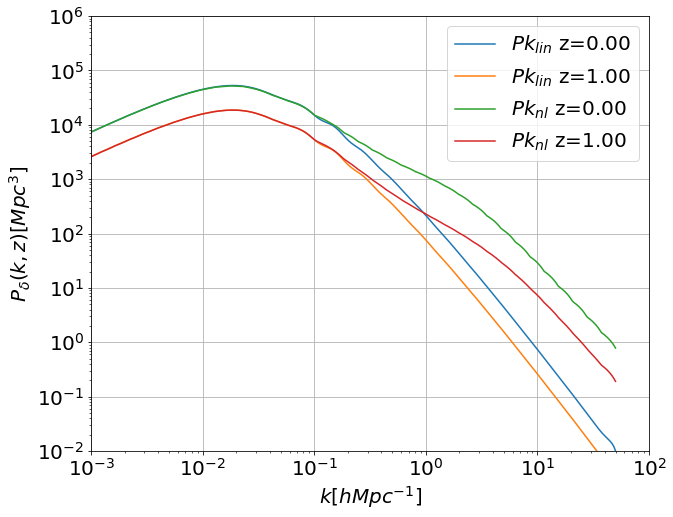

In [77]:
plt.figure(figsize=(10,8))
plt.plot(k_star, pk_lz0*gf[0],label=fr"$Pk_{{lin}}$ z={z_star[0]:.2f}")
plt.plot(k_star, pk_lz0*gf[1],label=fr"$Pk_{{lin}}$ z={z_star[1]:.2f}")
plt.plot(k_star, pk_nl[0], label=fr"$Pk_{{nl}}$ z={z_star[0]:.2f}")
plt.plot(k_star, pk_nl[1], label=fr"$Pk_{{nl}}$ z={z_star[1]:.2f}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.xlim([1e-3,1e2])
plt.ylim([1e-2,1e6])
plt.legend();

In [78]:
# CCL & Jax-cosmo

In [79]:
z_ccl = z_star[1].item()


cosmo_jax = jc.Cosmology(Omega_c=omega_c_ccl, Omega_b=omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0, w0=-1.0,wa=0.0)

pk_lin_ccl = ccl.linear_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 1./(1+z_ccl)) #last is scale factor 1=>z=0

pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_ccl))/cosmo_jax.h**3

In [80]:
cosmo_jax

Cosmological parameters: 
    h:        0.7 
    Omega_b:  0.05 
    Omega_c:  0.3 
    Omega_k:  0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.96 
    sigma8:   0.8005244775226154

In [81]:
# Classy

In [82]:
params_def_classy = {
    'output': 'mPk',
    'n_s': n_s_emu, 
    'h': h_emu,
    'omega_b': omega_b_emu,
    'omega_cdm':omega_c_emu,
    'N_ncdm': 1.0, 
    'deg_ncdm': 3.0, 
    'T_ncdm': 0.71611, 
    'N_ur': 0.00641,
    'm_ncdm':0.02,
    'z_max_pk' : 4.66,
    'P_k_max_h/Mpc' : 50.,
    'halofit_k_per_decade' : 80.,
    'halofit_sigma_precision' : 0.05
    }

if st.sigma8:
    params_def_classy['sigma8']=sigma8_emu
else:
    params_def_classy['A_s']=As_emu,



params_classy_lin =  params_def_classy.copy()
params_classy_lin['non_linear'] = 'none'

params_classy_nl =  params_def_classy.copy()
params_classy_nl['non_linear'] = 'halofit'


In [83]:
class_module_lin = Class()
class_module_lin.set(params_classy_lin)
class_module_lin.compute()


class_module_nl = Class()
class_module_nl.set(params_classy_nl)
class_module_nl.compute()


In [84]:
pk_class_lin = np.array([class_module_lin.pk(k * h_emu, z_ccl) for k in k_star])
pk_class_nl  = np.array([class_module_nl.pk(k * h_emu, z_ccl) for k in k_star])

In [86]:
pk_nonlin_ccl = ccl.nonlin_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 
                                        1./(1+z_ccl)) #last is scale factor 1=>z=0


pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_ccl))/cosmo_jax.h**3

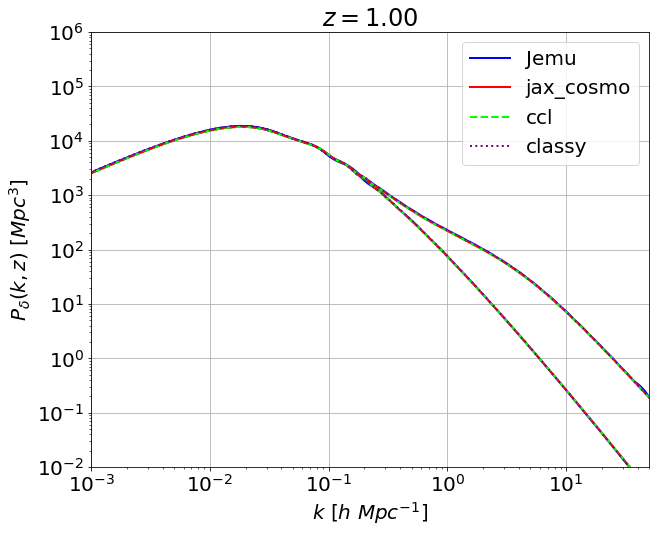

In [87]:
plt.figure(figsize=(10,8))
plt.plot(k_star,pk_lz0*gf[1],lw=2, c="b", label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=2, c="r", label="jax_cosmo")
plt.plot(k_star,pk_lin_ccl,lw=2, ls="--", c="lime", label=r"ccl")
plt.plot(k_star,pk_class_lin,lw=2, ls=":", c="purple",label="classy")


plt.plot(k_star,pk_nl[1],lw=2, c="b")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,pk_nonlin_jc,lw=2, c="r")#, label=r"$P_{{nl}}$ (jax_cosmo)")
plt.plot(k_star,pk_nonlin_ccl,lw=2, ls="--",c="lime")#,label=r"$P_{{nl}}$ (ccl)")
plt.plot(k_star,pk_class_nl,lw=2, ls=":", c="purple")#,label="classy")
#plt.plot(k_star,pk_nl, lw=1,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z)\ [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,5e1])
plt.ylim([1e-2,1e6]);

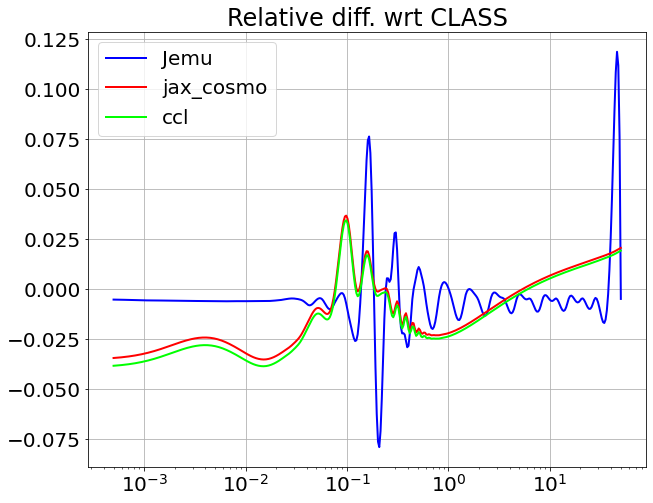

In [88]:
plt.figure(figsize=(10,8))
plt.plot(k_star,(pk_lz0*gf[1]-pk_class_lin)/pk_class_lin,lw=2, c="b", label="Jemu")
plt.plot(k_star,(pk_lin_jc-pk_class_lin)/pk_class_lin,lw=2, c="r", label="jax_cosmo")
plt.plot(k_star,(pk_lin_ccl-pk_class_lin)/pk_class_lin,lw=2, c="lime", label="ccl")
plt.legend()
plt.grid()
plt.xscale("log");
plt.title("Relative diff. wrt CLASS");

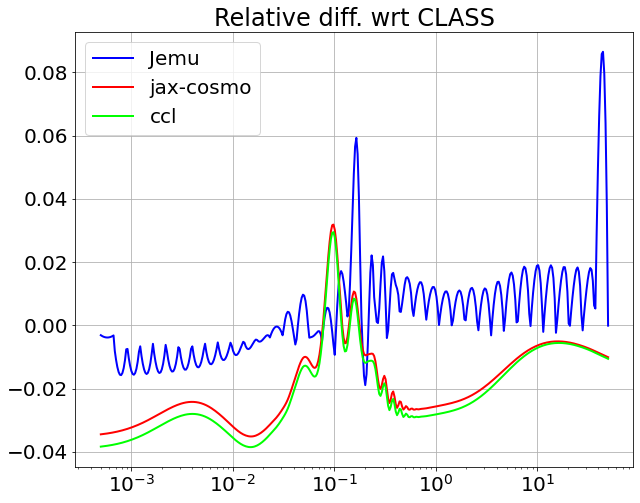

In [89]:
plt.figure(figsize=(10,8))

plt.plot(k_star,(pk_nl[1]-pk_class_nl)/pk_class_nl,lw=2, c="b", label="Jemu")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,(pk_nonlin_jc-pk_class_nl)/pk_class_nl,lw=2, c="r", label="jax-cosmo")#, label=r"$P_{{nl}}$ (jax_cosmo)")
plt.plot(k_star,(pk_nonlin_ccl-pk_class_nl)/pk_class_nl,lw=2,c="lime",  label="ccl")#,label=r"$P_{{nl}}$ (ccl)")
plt.grid()
plt.legend()
plt.xscale("log")
plt.title("Relative diff. wrt CLASS");
#